In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Read the exported CSV file
dat = pd.read_csv("Data/ML_data.csv")

# Perform data preprocessing
dat["gender"] = dat["gender"].astype(int)
feature_cols = [col for col in dat.columns if "pre_" in col or "income_" in col or "age_" in col or "gender" in col]
dat[feature_cols] = (dat[feature_cols] - dat[feature_cols].mean()) / dat[feature_cols].std()

# Filter dat based on test != 1
train_data = dat[dat["test"] != 1]
test_data = dat[dat["test"] == 1]

n_features = len(feature_cols)
treatment_groups = train_data["tg"].nunique()

# Define the desired order of treatment groups
treatment_groups_order = ['3x1', '4x2', '6x2', '4x3', '5x3', '6x3', 'control']

# Convert tg to one-hot vector for training data
tg_one_hot = pd.get_dummies(train_data["tg"].astype(pd.CategoricalDtype(categories=treatment_groups_order, ordered=True)))

# Convert tg to one-hot vector for test data
tg_test_one_hot = pd.get_dummies(test_data["tg"].astype(pd.CategoricalDtype(categories=treatment_groups_order, ordered=True)))

# Define the neural network architecture
hidden_size = 128
# the bottleneck projects all HTE of a given treatment to a single value that is then scaled for each treatment arm
# this helps the model regulate the HTEs, and learn base and HTE separately and then combine them -- similar to Dueling networks
het_bottleneck_size = 1

class Net(nn.Module):
    def __init__(self, n_features, hidden_size):
        super(Net, self).__init__()
        self.hidden = nn.Linear(n_features, hidden_size)
        self.base = nn.Linear(hidden_size, 1)
        self.het_bottleNeck = nn.Linear(hidden_size, het_bottleneck_size)
        self.het = nn.Linear(het_bottleneck_size, treatment_groups)

    def forward(self, x, tg):
        x = self.hidden(x)
        x = torch.relu(x)
        x_het = self.het_bottleNeck(x)
        x_base = self.base(x)
        x_het = torch.relu(x_het)
        x_het = self.het(x_het)
        x_het = x_het*tg
        x_het = torch.sum(x_het, dim=1, keepdim=True)
        x = x_base + x_het
        return x

model = Net(n_features, hidden_size)

# Define the loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Convert the training data to tensors
X_train_tensor = torch.tensor(train_data[feature_cols].values, dtype=torch.float32)
y_train_tensor = torch.tensor(train_data["sub"].values.reshape(-1, 1), dtype=torch.float32)
tg_train_tensor = torch.tensor(tg_one_hot.values, dtype=torch.float32)

# Create data loader for training
batch_size = 128
train_data = TensorDataset(X_train_tensor, y_train_tensor, tg_train_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


Epoch: 1, Train Loss: 0.3917
Epoch: 2, Train Loss: 0.3823
Epoch: 3, Train Loss: 0.3813
Epoch: 4, Train Loss: 0.3815
Epoch: 5, Train Loss: 0.3811
Epoch: 6, Train Loss: 0.3807
Epoch: 7, Train Loss: 0.3804
Epoch: 8, Train Loss: 0.3806
Epoch: 9, Train Loss: 0.3805
Epoch: 10, Train Loss: 0.3807
Epoch: 11, Train Loss: 0.3804
Epoch: 12, Train Loss: 0.3805
Epoch: 13, Train Loss: 0.3804
Epoch: 14, Train Loss: 0.3803
Epoch: 15, Train Loss: 0.3800
Epoch: 16, Train Loss: 0.3801
Epoch: 17, Train Loss: 0.3802
Epoch: 18, Train Loss: 0.3802
Epoch: 19, Train Loss: 0.3801
Epoch: 20, Train Loss: 0.3801
Epoch: 21, Train Loss: 0.3800
Epoch: 22, Train Loss: 0.3799
Epoch: 23, Train Loss: 0.3800
Epoch: 24, Train Loss: 0.3796
Epoch: 25, Train Loss: 0.3798
Epoch: 26, Train Loss: 0.3799
Epoch: 27, Train Loss: 0.3798
Epoch: 28, Train Loss: 0.3801
Epoch: 29, Train Loss: 0.3799
Epoch: 30, Train Loss: 0.3798
Epoch: 31, Train Loss: 0.3797
Epoch: 32, Train Loss: 0.3799
Epoch: 33, Train Loss: 0.3796
Epoch: 34, Train Lo

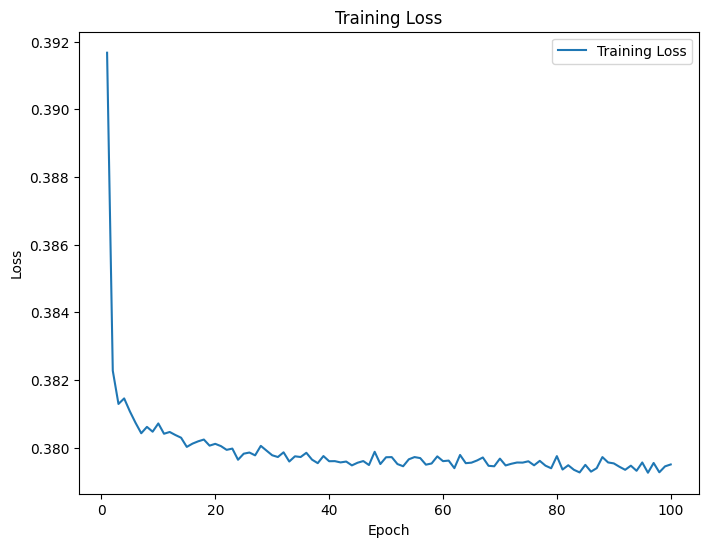

In [2]:

# Train the neural network
num_epochs = 100
train_losses = []

## fix the random seed
torch.manual_seed(0)
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_x, batch_y, batch_tg in train_loader:
        # Forward pass
        y_pred = model(batch_x, batch_tg)
        loss = loss_fn(y_pred, batch_y)
        train_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Print the loss for monitoring
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.4f}")

# Plot the training loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()


In [3]:

# Predict the propensity of being a subscriber for test data
test_data_tensor = torch.tensor(test_data[feature_cols].values, dtype=torch.float32)
tg_test_tensor = torch.tensor(tg_test_one_hot.values, dtype=torch.float32)

model.eval()
with torch.no_grad():
    hidden_layer = torch.relu(model.hidden(test_data_tensor))
    model_base = model.base(hidden_layer)
    model_het = model.het_bottleNeck(hidden_layer)
    model_het = torch.relu(model_het)
    model_het = model.het(model_het)
    ## add model_base to medel_het dimensions are not the same so we need to tile model_base
    model_base = model_base.repeat(1, treatment_groups)
    output = model_base + model_het
    propensity_scores = torch.sigmoid(output).numpy()


## convert propensity scores to a dataframe with column names as treatment groups and append "sub_propensity" to column names
propensity_scores_df = pd.DataFrame(propensity_scores, columns=["sub_prop_" + t for t in treatment_groups_order])
## append propensity scores to test_data and save 
test_data = pd.concat([test_data.reset_index(drop=True), propensity_scores_df], axis=1)
test_data.to_csv("Data_generate/ML_test_data_with_sub_propensity.csv", index=False)
